dt: 0.000009, Steps: 110000
------------------------------
Initial Mass: 0.177218170363034
Final Mass:   0.177218170362806
Difference:   -2.28e-13
------------------------------


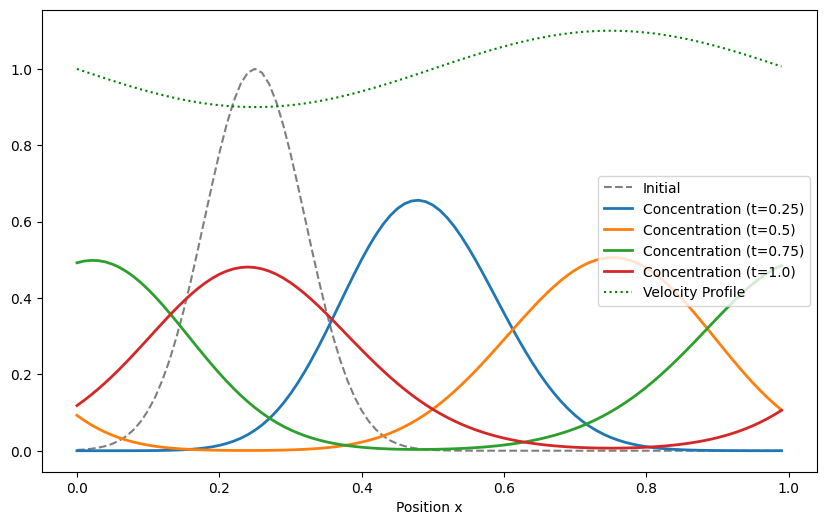

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# --- 1. Parameters ---
L = 1.0             
Nx = 100            
T = 1.0             
D = 0.01           

dx = L / Nx  
x = np.linspace(0, L, Nx, endpoint=False) 

# Variable Velocity
c = 1.0 - 0.1 * np.sin(2 * np.pi * x)

# Stability Check
dt = 0.001 * dx / np.max(c)
Nt = int(T / dt)
print(f"dt: {dt:.6f}, Steps: {Nt}")

# --- 2. Matrix Construction (Direct Diagonal Assignment) ---
# Initialize an empty sparse matrix in LIL format (efficient for building)
A = sparse.lil_matrix((Nx, Nx))

# Coefficients
gamma = dt / (2 * dx)
beta = D * dt / dx**2

# --- Pre-calculate Full Diagonal Arrays ---
# These arrays are size N. Index 'i' corresponds to Row 'i'.

# Main Diagonal (Self): 1 - 2*beta
# (Advection cancels out for self term in centered flux)
diag_main = (1.0 - 2*beta) * np.ones(Nx)

# Lower Diagonal Logic (Neighbor i-1): beta + gamma * c_{i-1}
# We use roll(c, 1) so that index i holds c[i-1]
c_im1 = np.roll(c, 1)
diag_lower = beta + gamma * c_im1

# Upper Diagonal Logic (Neighbor i+1): beta - gamma * c_{i+1}
# We use roll(c, -1) so that index i holds c[i+1]
c_ip1 = np.roll(c, -1)
diag_upper = beta - gamma * c_ip1

# --- Assign to Matrix using Slicing ---
# 1. Set Main Diagonal
A.setdiag(diag_main)

# 2. Set Lower Diagonal (A[i, i-1])
# We take elements 1 to N-1 from our diag_lower array
# and place them into the matrix offset by -1
A.setdiag(diag_lower[1:], k=-1)

# 3. Set Upper Diagonal (A[i, i+1])
# We take elements 0 to N-2 from our diag_upper array
# and place them into the matrix offset by +1
A.setdiag(diag_upper[:-1], k=1)

# 4. Set Periodic Corners (Manually)
# Top-Right (Row 0, Col N-1): Left Neighbor of 0
# Use the Lower Diag logic for index 0
A[0, Nx-1] = diag_lower[0]

# Bottom-Left (Row N-1, Col 0): Right Neighbor of N-1
# Use the Upper Diag logic for index N-1
A[Nx-1, 0] = diag_upper[Nx-1]

# Convert to CSR for fast simulation
A = A.tocsr()

# --- 3. Simulation ---
u_init = np.exp(-100 * (x - 0.25)**2)
u = u_init.copy()

history = [u.copy()]
plot_every = Nt // 4

for n in range(Nt):
    u = A.dot(u)
    if n % plot_every==0 and n!=0 :
        history.append(u.copy())

# --- 4. Mass Conservation Check ---
initial_mass = np.sum(u_init) * dx
final_mass = np.sum(u) * dx
diff = final_mass - initial_mass

print("-" * 30)
print(f"Initial Mass: {initial_mass:.15f}")
print(f"Final Mass:   {final_mass:.15f}")
print(f"Difference:   {diff:.2e}") 
print("-" * 30)

# --- 5. Visualization ---
plt.figure(figsize=(10,6))

plt.plot(x, history[0], 'k--', alpha=0.5, label='Initial')
plt.plot(x, history[1], linewidth=2, label=f'Concentration (t={T/4})')
plt.plot(x, history[2], linewidth=2, label=f'Concentration (t={T/2})')
plt.plot(x, history[3], linewidth=2, label=f'Concentration (t={3/4*T})')
plt.plot(x, u,  linewidth=2, label=f'Concentration (t={T})')

# Plot Velocity (scaled)
c_scaled = (c / np.mean(c)) 
plt.plot(x, c_scaled, 'g:', label='Velocity Profile')

plt.xlabel('Position x')
plt.legend()
plt.show()
